In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


import warnings
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

# House Prices: Advanced Regression Techniques

**Competition Description**
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

# Import Data

In [2]:
print("imported data..")
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
print("Train set size:", train.shape)
print("Test set size:", test.shape)

imported data..
Train set size: (1460, 81)
Test set size: (1459, 80)


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


**Data Processing**

In [5]:
train_ID = train['Id']
test_ID = test['Id']
# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

Lets look at the distribution of our target variable to see if it fits a normal distribution, due to the parametric nature of our analysis procedure.

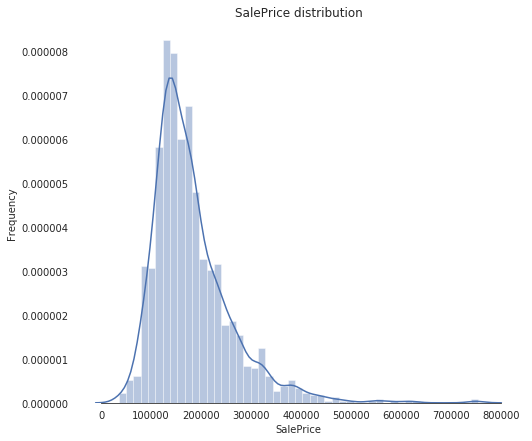

In [6]:
#Before the normalisation
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

# Deleting the more visibly obvious outliers
# 4500 exceeds the central tendecy of of the houses in that price point and all the houses in the dataset
# will deal with more subtle outlers later.
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

> The graph shows that our data is skewed to the right.

This is to make sure that SalesPrice values are distributed normaly using function log1p which  applies log(1+x) to all elements of the column which fixes the skeweness of the distribution.


 mu = 12.02 and sigma = 0.40



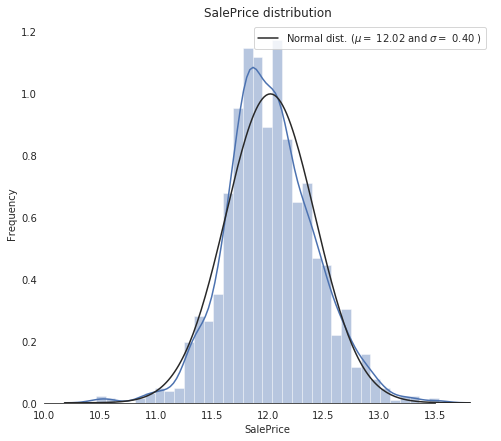

In [7]:

#We use the numpy fuction log1p 
train["SalePrice"] = np.log1p(train["SalePrice"])
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

> The graph shows that our data now looks more normal

In [8]:
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# concatinate the train and the test set as features for tranformation to avoid mismatch
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print('Features size:', features.shape)

Features size: (2917, 79)


# Feature Engineering

We now start the process of preparing our features, we first find, the percentage of missing data in each column and we determine whether the threshold of missing values is acceptable or not.

In [9]:

# function for determining the threshold of missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45)]

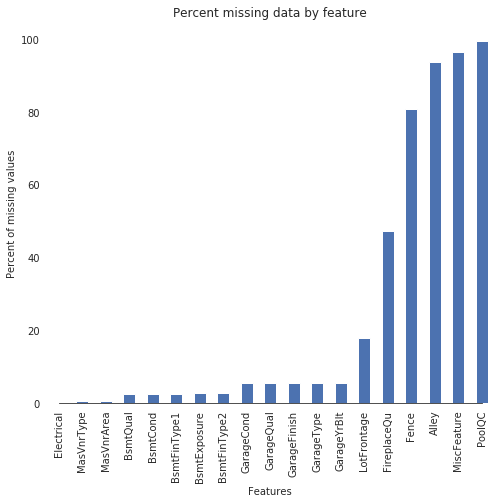

In [10]:
# visualising missing values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

These visualisation helps determine which values need to be imputed, We impute them by proceeding sequentially through features with missing values.

In [11]:

# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# data description says NA means typical
features['Functional'] = features['Functional'].fillna('Typ')
# has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
features['Electrical'] = features['Electrical'].fillna("SBrkr")
#  Only one NA value, We set 'TA' (which is the most frequent) for the missing value in KitchenQual
features['KitchenQual'] = features['KitchenQual'].fillna("TA")

# Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
# Fill in again with most frequent
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# data description says NA means "No Pool", majority of houses have no Pool at all in general.
features["PoolQC"] = features["PoolQC"].fillna("None")

# Replacing missing data with 0 (Since No garage = no cars in such garage.)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
# Replacing missing data with None
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
# For all these categorical basement-related features, NaN means that there is no basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

# 'RL' is by far the most common value. So we can fill in missing values with 'RL'
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
print('Features size:', features.shape)

Features size: (2917, 79)


In [12]:
# Filling the rest of the categorical features
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

In [13]:
# Filling in the rest of the NA's
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))


After imputing features with missing values, is there any remaining missing values?

In [14]:
# Check the state of missing values
missing = percent_missing(features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

>  No more missing values

One of the other methods that we tried that did not work well in selecting the feature and improving the accuracy was Backward Elimination with Adjusted R-squared. (Expand below to view commented code.)

In [15]:
# import statsmodels.formula.api as sm
# def backwardElimination(x, sl):
#     numVars = len(x[0])
#     for i in range(0, numVars):
#         regressor_OLS = sm.OLS(y, x).fit()
#         maxVar = max(regressor_OLS.pvalues).astype(float)
#         if maxVar > sl:
#             for j in range(0, numVars - i):
#                 if (regressor_OLS.pvalues[j].astype(float) == maxVar):
#                     x = np.delete(x, j, 1)
#     regressor_OLS.summary()
#     return x

# #start elimination with 5% significance level for best parameters
# SL = 0.01
# X_opt = features
# y = y
# features = backwardElimination(X_opt, SL)

# More feature engineering

Looking at the distribution of the numeric features. Ideally we would like all our data to be normaly distributed. Id these is not normally distributed that could violate the assumptions of parametric statistics. If the data deviate strongly from the assumptions of a parametric procedure, using the parametric procedure could lead to incorrect conclusions.  

In [16]:
# First we need to find all numeric features in the data
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

Visualize the destributions of the numeric features. This will allow us to visually see the ditributions of all our numeric data.

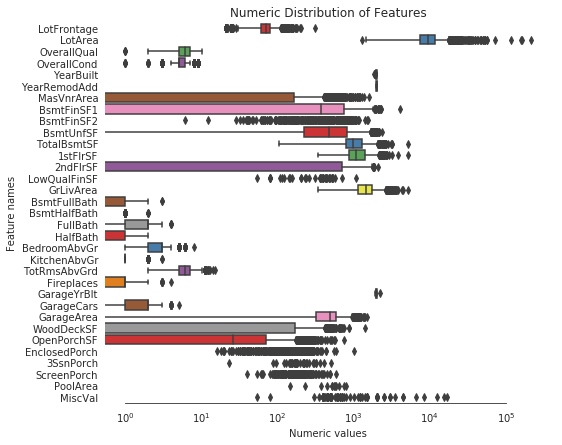

In [17]:
# Box plots for all our numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=features[numerics2] , orient="h", palette="Set1")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

 > The visualisation show that is some data that is not normaly distributed(Skewed)

In [18]:
# Find the skewed  numerical features
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)


There are 25 numerical features with Skew > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

We use the scipy function boxcox1p which computes the Box-Cox transformation. The goal is to find a simple transformation that leads to normality. 

In [19]:
# Normalise skewed features
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
    

We check the data after normalisation, is there any remaining skewed values?

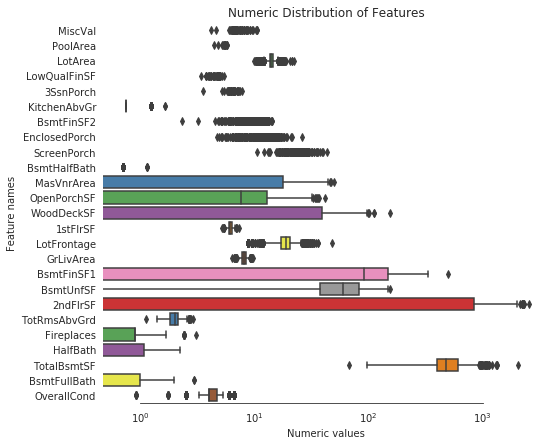

In [20]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=features[skew_index] , orient="h", palette="Set1")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)



>  [MasVnrArea, OpenPorchSF, WoodDeckSF, BsmtFinSF1] could not be normalised therefore call to be droped.

Since area related features are very important to determine house prices, we add a few more features which is the total area of floors, bathrooms and porch area of each house before we continue droping these numeric colum

In [21]:
# Calculating totals before droping less significant columns

#  Adding total sqfootage feature 
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
#  Adding total bathrooms feature
features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
#  Adding total porch sqfootage feature
features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])


In [22]:
# Not normaly distributed can not be normalised and has no central tendecy
features = features.drop(['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1','2ndFlrSF'], axis=1)


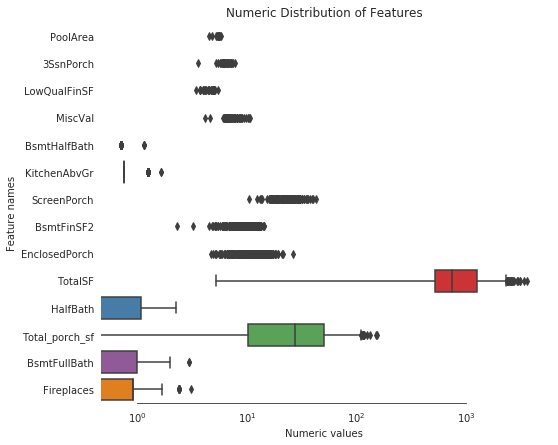

In [23]:
# Check the distribution after dopping the skewed features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics3 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics3.append(i)
        
skew_features = features[numerics3].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=features[skew_index] , orient="h", palette="Set1")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)


> The are no more skewed numerical variables

In [24]:
# Adding new simplified features (1 = present, 0 = not present)
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

print('Features size:', features.shape)

Features size: (2917, 81)


In [25]:
# Encoding the finalized features
final_features = pd.get_dummies(features).reset_index(drop=True)
print('Features size:', features.shape)
final_features.head()

Features size: (2917, 81)


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,18.144572,13.833055,7,3.991517,2003,2003,0.0,29.991052,422.488452,5.939033,...,0,0,0,1,0,0,0,0,1,0
1,20.673625,14.117918,6,6.000033,1976,1976,0.0,44.135410,593.888092,6.234989,...,0,0,0,1,0,0,0,0,1,0
2,18.668046,14.476513,7,3.991517,2001,2002,0.0,56.896528,450.079654,5.994335,...,0,0,0,1,0,0,0,0,1,0
3,17.249650,14.106197,7,3.991517,1915,1970,0.0,64.808848,378.854517,6.027703,...,0,0,0,1,1,0,0,0,0,0
4,21.314282,15.022009,8,3.991517,2000,2000,0.0,61.166371,545.309849,6.161220,...,0,0,0,1,0,0,0,0,1,0


Separating the training(X,y) and the testing(X_sub) set

In [26]:
# Spliting the data back to train(X,y) and test(X_sub)
X = final_features.iloc[:len(y), :]
X_test = final_features.iloc[len(X):, :]
print('Features size for train(X,y) and test(X_test):')
print('X', X.shape, 'y', y.shape, 'X_test', X_test.shape)


Features size for train(X,y) and test(X_test):
X (1458, 334) y (1458,) X_test (1459, 334)


# Finalising features

Outlier removal is usually safe, for outliers that are very visible in certain features. We decided to delete these outliers as they are  likely to introduce bias in our regression functions.


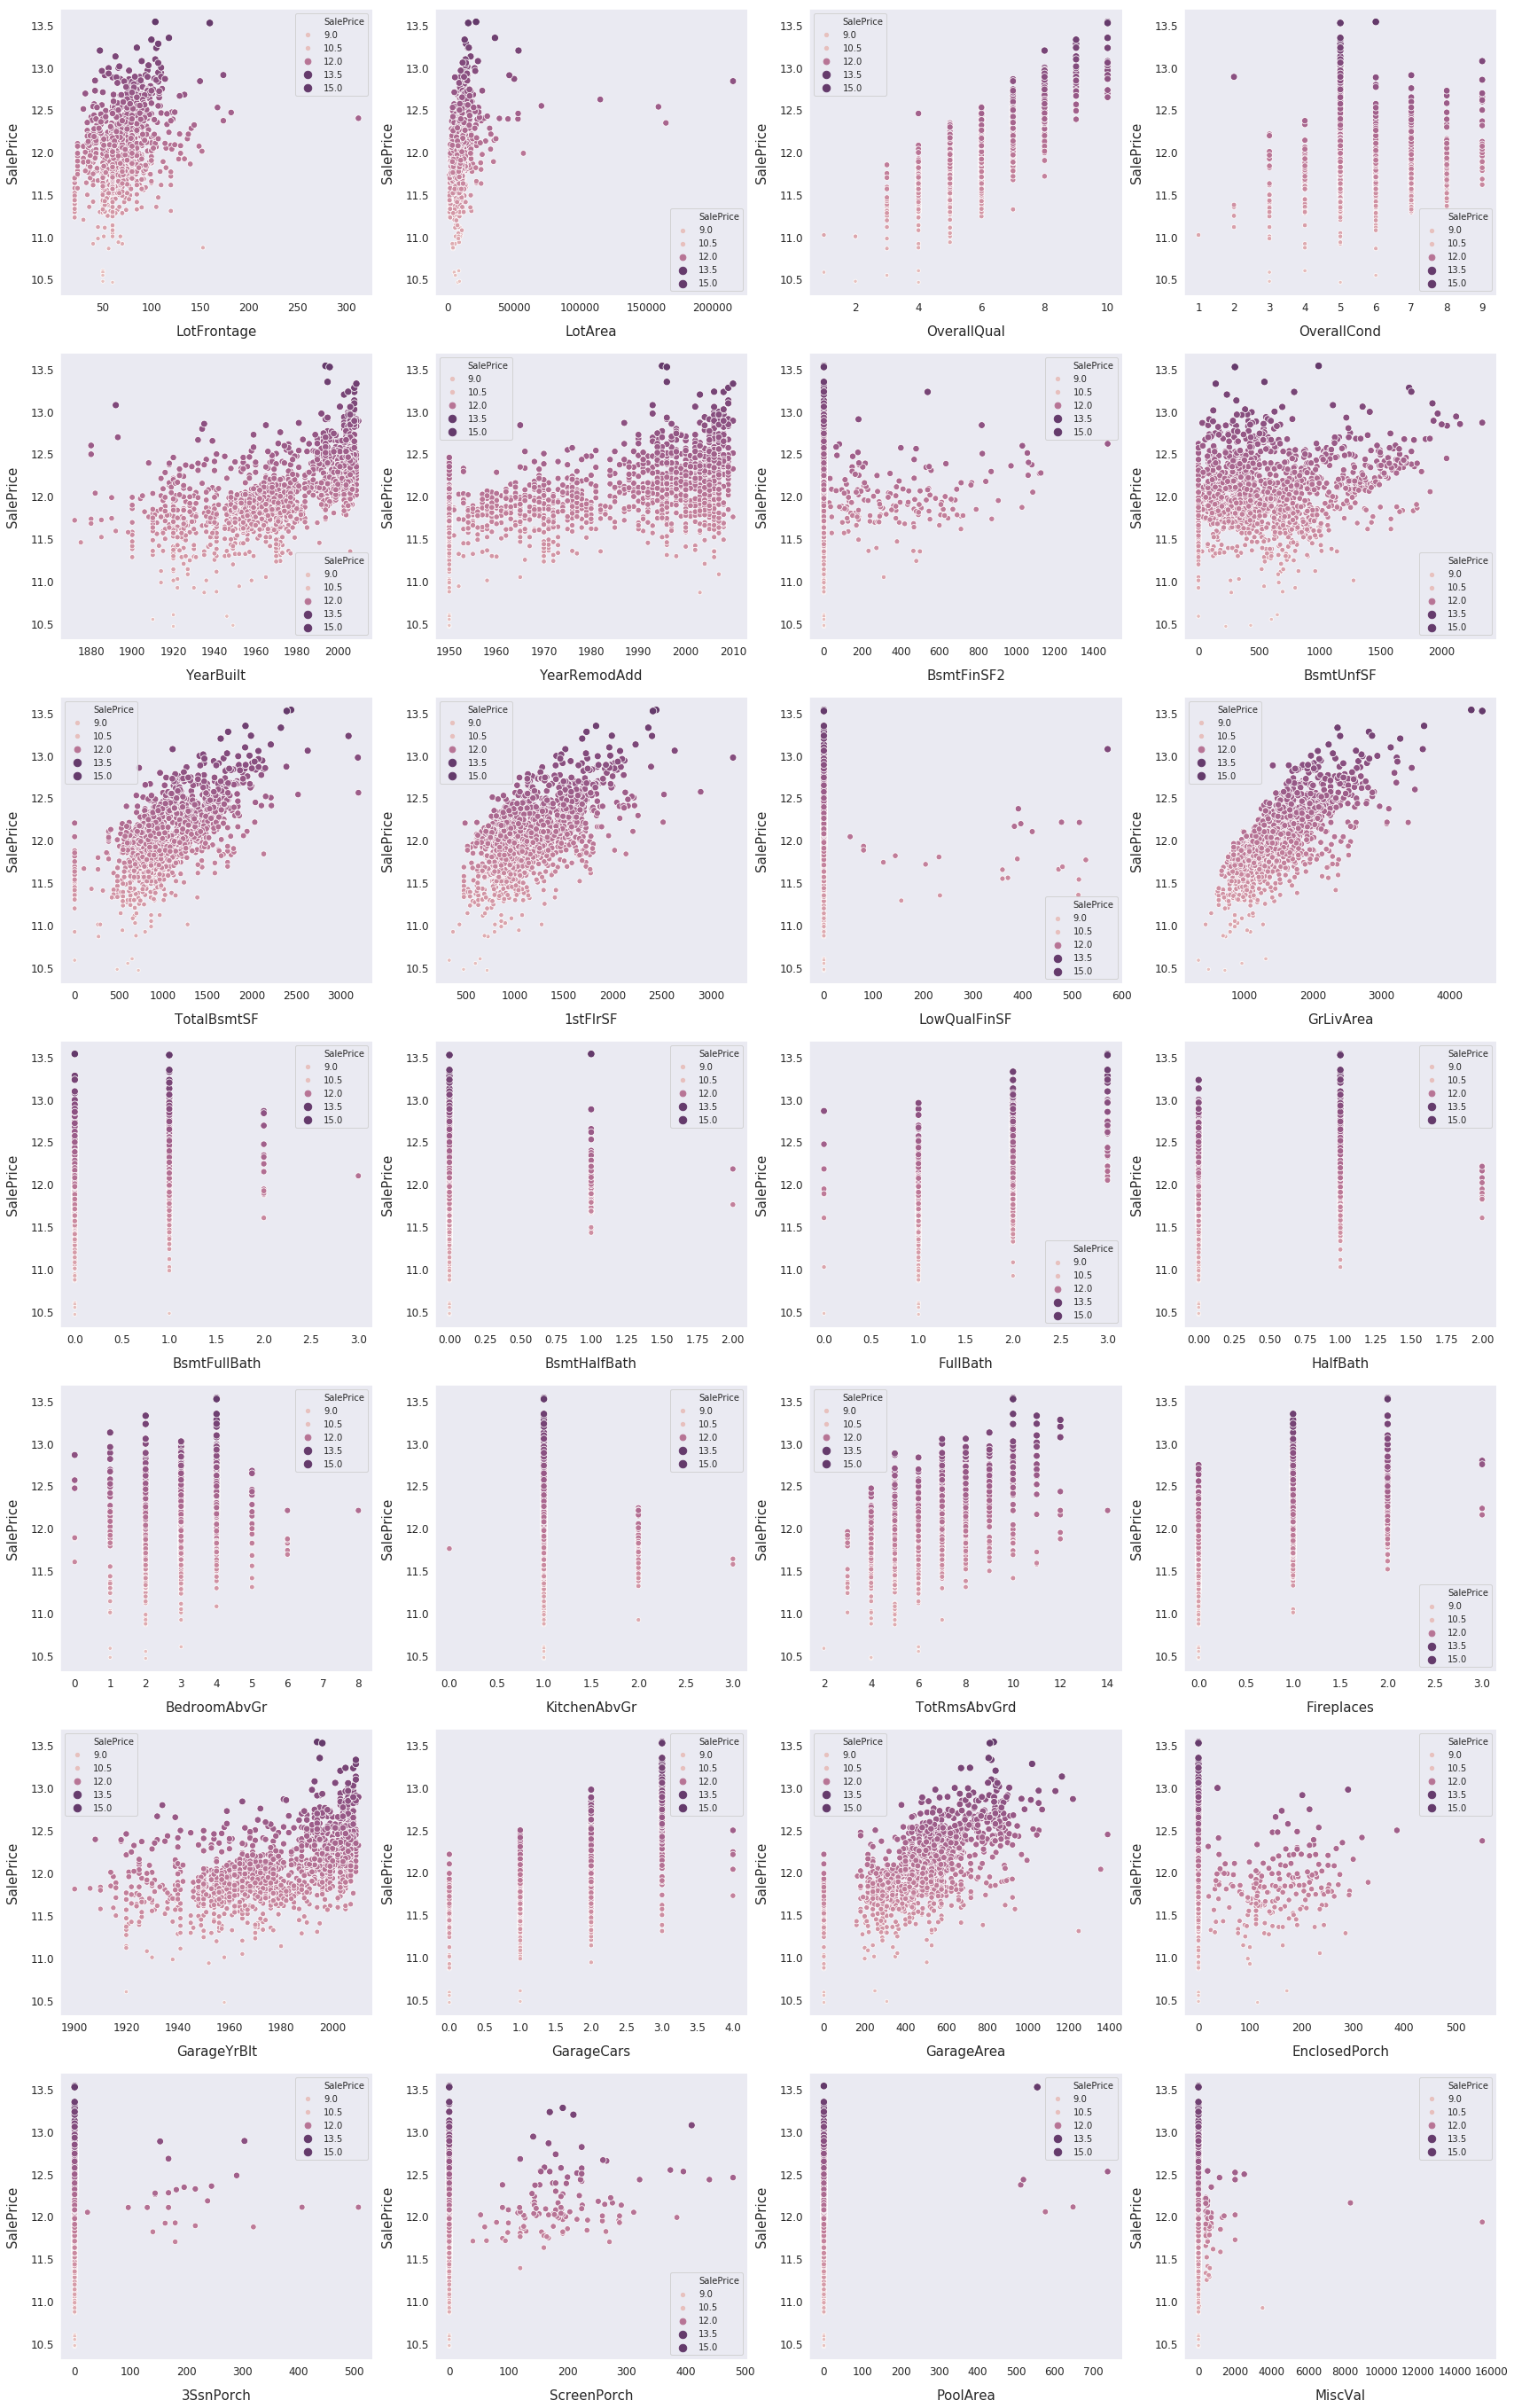

In [27]:
# Finding numeric features
sns.set_style("dark")
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics4 = []
for i in X.columns:
    if X[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numerics4.append(i)     
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 80))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

cmap = sns.cubehelix_palette(dark=0.3, light=0.8, as_cmap=True)

for i, feature in enumerate(list(X[numerics4]), 1):    
    plt.subplot(len(list(numerics4)), 4, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', size='SalePrice', palette=cmap, data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

In [28]:
# Removes outliers 
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [29]:

# Removes colums where the threshold of zero's is (> 99.95), means has only zero values 
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.95:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_test = X_test.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_test', X_test.shape)

X (1453, 331) y (1453,) X_test (1459, 331)


# Start Model Building

We use the kfolds Cross Validation function where K=10 which is the number of holdout sets. The function has no shuffle attribute, we add then one line of code shuffle=True, in order to shuffle the dataset prior to cross-validation.


In [30]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# model scoring and validation function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,scoring="neg_mean_squared_error",cv=kfolds))
    return (rmse)

# rmsle scoring function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

Another difficulty was to find the most optimal hyperparameters.Applying Grid Search was onr of the methods we tried to get the best hyperparameters for our base models. Although this is very time consuming and computationally expensive the use of a pipeline seemed to be much more easier and effective. (Expand below to view commented code.)



In [31]:
# Grid search CV
# from sklearn.model_selection import GridSearchCV
# param = {'alpha':[1.0,0.0,0.1,0.01,0.001]} 
# model = Lasso()
# grid_search = GridSearchCV(estimator=reg, param_grid=param, cv=5) 
# grid_search.fit(X, y)
# print(grid_search.best_params_)
# print(grid_search.best_estimator_)

Created 3 models RidgeCV, LassoCV, ElasticNetCV and are linear models with built-in cross validation.
We a going to use these nodels together to make the final prediction.

In [32]:

# setup models hyperparameters using a pipline
# The purpose of the pipeline is to assemble several steps that can be cross-validated together, while setting different parameters.
# This is a range of values that the model considers each time in runs a CV
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]


# Kernel Ridge Regression : made robust to outliers
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

# LASSO Regression : made robust to outliers
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas2,random_state=42, cv=kfolds))

# Elastic Net Regression : made robust to outliers
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                         alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))

# store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet}
predictions = {}
scores = {}

for name, model in models.items():
    
    model.fit(X, y)
    predictions[name] = np.expm1(model.predict(X))
    
    score = cv_rmse(model, X=X)
    scores[name] = (score.mean(), score.std())
    

# Evaluate Model Performance

Now we use 10-fold stacking , we first split the training data into 10 folds. Then we will do 10 iterations. In each iteration, we train every base model on 9 folds and predict on the remaining fold (holdout fold).

In [33]:
# get the performance of each model on training data(validation set)
print('---- Score with CV_RMSLE-----')
score = cv_rmse(ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))





---- Score with CV_RMSLE-----
Ridge score: 0.1022 (0.0140)

Lasso score: 0.1030 (0.0145)

ElasticNet score: 0.1032 (0.0146)



In [34]:
#Fit the training data X, y
print('----START Fit----',datetime.now())
print('Elasticnet')
elastic_model = elasticnet.fit(X, y)
print('Lasso')
lasso_model = lasso.fit(X, y)
print('Ridge')
ridge_model = ridge.fit(X, y)



----START Fit---- 2020-03-24 16:56:13.266580
Elasticnet
Lasso
Ridge


# Ensemble prediction on blended models

All of the models individually achieved scores between 0.10 and 0.13, but when the predictions of those models are blended, they get about 0.090. That's because those models are actually overfitting to certain degree. They are very good at predicting a subset of houses, and they fail at predicting the rest of the dataset. When their predictions are blended, those models complement each other.

In [35]:
# model blending function using fitted models to make predictions
def blend_models(X):
    return ((elastic_model.predict(X)) + (lasso_model.predict(X)) + (ridge_model.predict(X)))/3
blended_score = rmsle(y, blend_models(X))
print('RMSLE score on train data:')
print(rmsle(y, blend_models(X)))

RMSLE score on train data:
0.09169726606188743


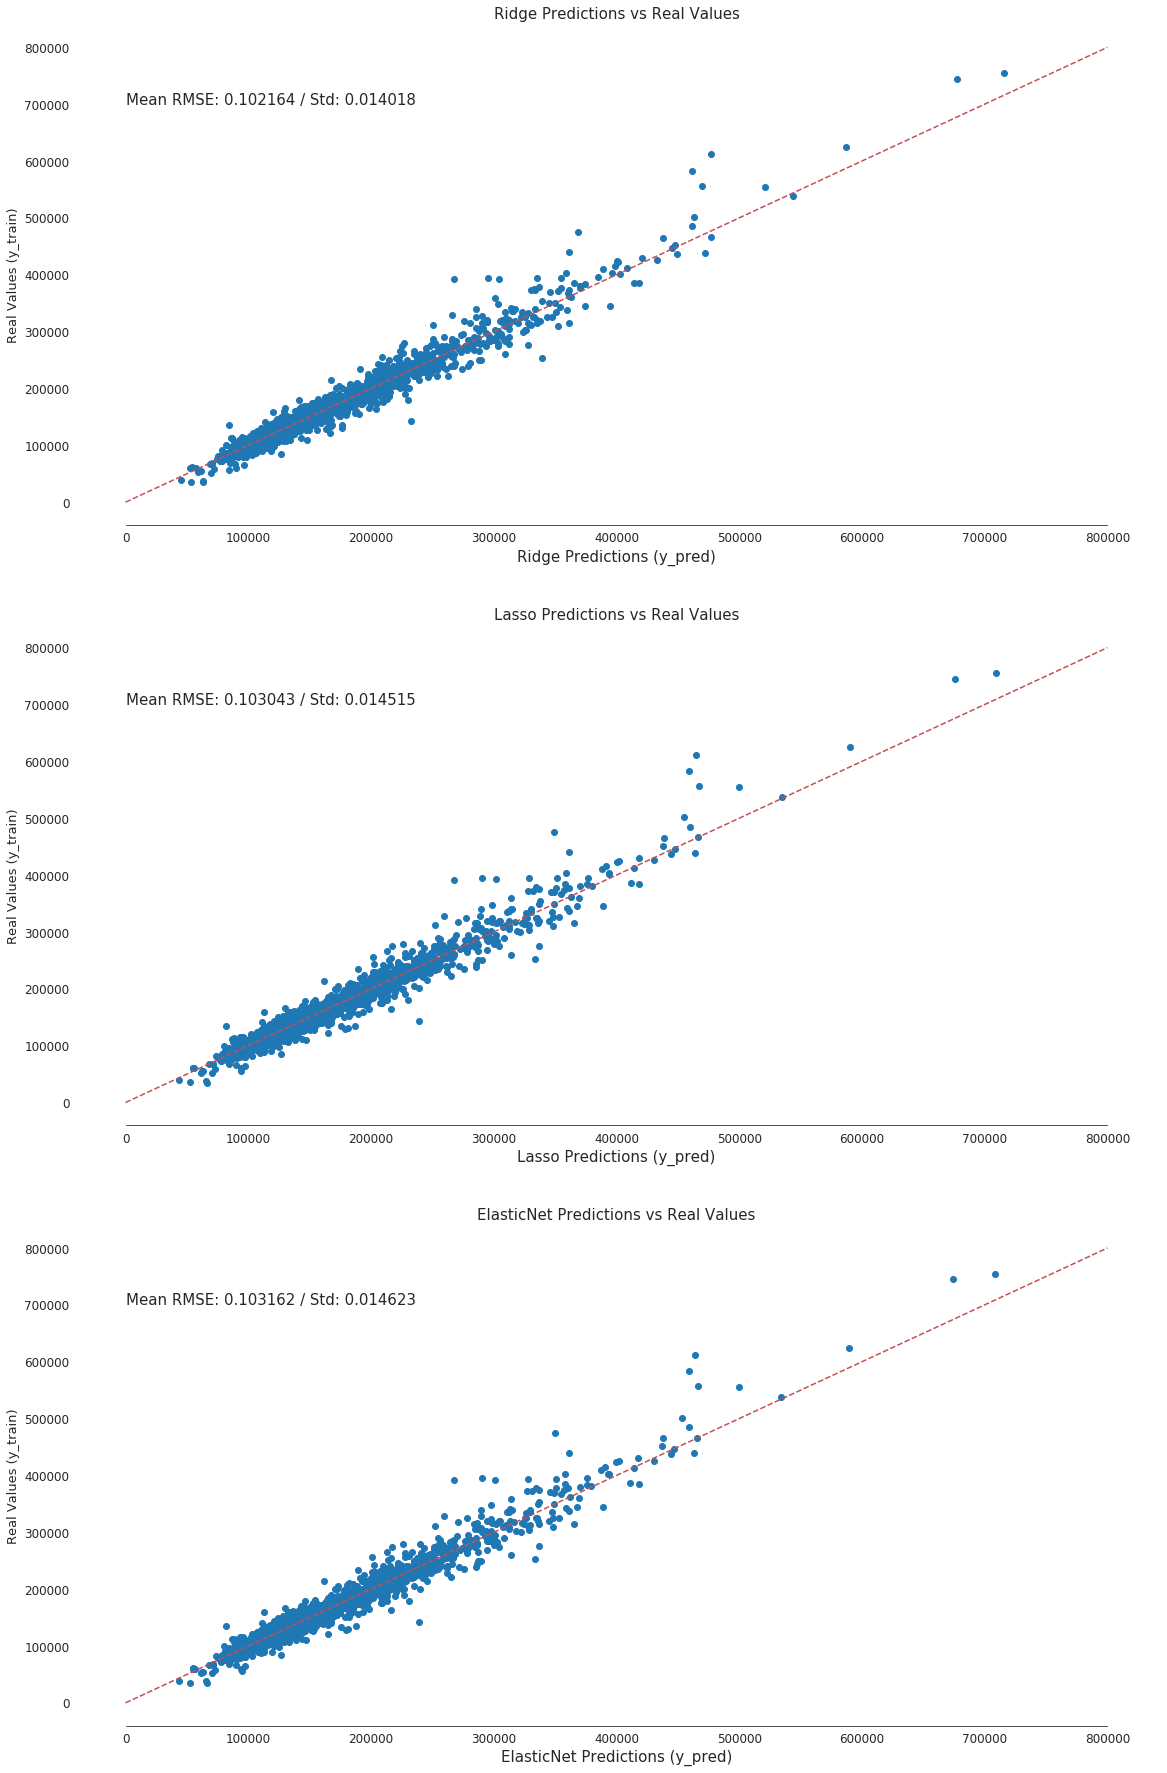

In [36]:
# visualise model performance
sns.set_style("white")
fig, axs = plt.subplots(ncols=0, nrows=3, figsize=(8, 7))
plt.subplots_adjust(top=3.5, right=2)

for i, model in enumerate(models, 1):
    plt.subplot(3, 1, i)
    plt.scatter(predictions[model], np.expm1(y))
    plt.plot([0, 800000], [0, 800000], '--r')

    plt.xlabel('{} Predictions (y_pred)'.format(model), size=15)
    plt.ylabel('Real Values (y_train)', size=13)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.title('{} Predictions vs Real Values'.format(model), size=15)
    plt.text(0, 700000, 'Mean RMSE: {:.6f} / Std: {:.6f}'.format(scores[model][0], scores[model][1]), fontsize=15)
    ax.xaxis.grid(False)
    sns.despine(trim=True, left=True)
plt.show()

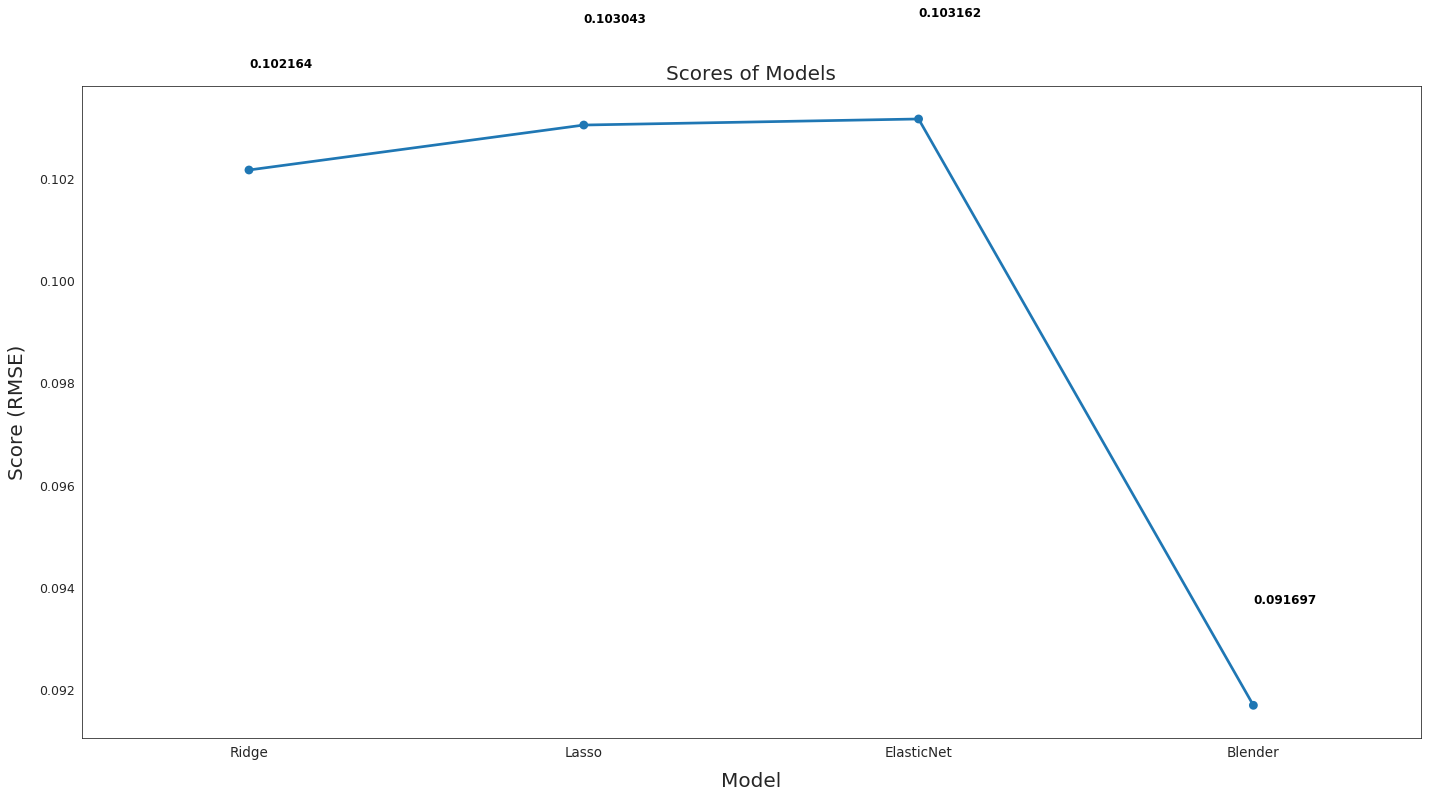

In [37]:
scores['Blender'] = (blended_score, 0)
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

# Model Predictions

In [39]:
# get the target variable/ y_test with X_test
print('Predict submission')
y_test_r = pd.read_csv("../data/sample_submission.csv")
submission = pd.read_csv("../data/sample_submission.csv")
y_test = np.log1p(y_test_r.iloc[:,1].values)
submission.iloc[:,1] = np.expm1(blend_models(X_test))
blended_score = rmsle(y_test, blend_models(X_test))


Predict submission


# Submission

In [40]:
submission.to_csv("new_submission.csv", index=False)
print('Save submission', datetime.now(),)

Save submission 2020-03-24 16:58:55.894685


In [41]:
submission.head()

,Id,SalePrice
0,1461,118316.240614
1,1462,155352.574965
2,1463,185565.352468
3,1464,203387.808056
4,1465,193350.825727


Score 0.11562